# Project 4.2 - Object Detector

This notebook implements the training and evaluation of a CNN classifier for pothole detection.

## Tasks:
1. Build a CNN to classify object proposals (2 classes: pothole + background)
2. Build a dataloader with class imbalance handling
3. Finetune the network on the training set
4. Evaluate classification accuracy on the validation set

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Local modules
from model import ProposalClassifier, create_model
from detector_dataset import (
    ProposalDataset,
    create_data_loaders,
    create_train_val_split,
    get_transforms
)
from train import (
    train_model,
    evaluate,
    print_evaluation_report,
    plot_training_history,
    get_optimizer,
    get_scheduler
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
# Configuration
DATA_DIR = "./potholes"
TRAINING_DATA_PATH = "training_data.npy"

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
NEG_POS_RATIO = 3  # Max ratio of negatives to positives
VAL_RATIO = 0.2

# Check if training data exists
if not os.path.exists(TRAINING_DATA_PATH):
    raise FileNotFoundError(
        f"Training data not found: {TRAINING_DATA_PATH}\n"
        "Please run Part 1 (main.ipynb) first to generate training data."
    )

print(f"Configuration loaded")

Configuration loaded


## Task 1: Build CNN Classifier

We use a pretrained ResNet backbone with a custom classification head for 2 classes (pothole + background).

In [4]:
# Create model
model = create_model(
    model_type='resnet18',
    num_classes=2,
    pretrained=True,
    freeze_backbone=False
)

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 11,308,354
Trainable parameters: 11,308,354


/Users/williampeytz/Documents/GitHub/DLCV4/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/williampeytz/Documents/GitHub/DLCV4/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Test forward pass
test_input = torch.randn(4, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output (logits): {test_output}")

Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 2])
Output (logits): tensor([[ 0.2509,  0.7432],
        [-0.4082,  0.3367],
        [ 0.1152, -0.2695],
        [ 0.0291,  0.3392]], device='mps:0', grad_fn=<LinearBackward0>)


## Task 2: Build DataLoader

Create data loaders with class imbalance handling using:
- Weighted random sampling
- Negative-to-positive ratio limiting
- Class-weighted loss

In [6]:
# Load training data from Part 1
training_data = np.load(TRAINING_DATA_PATH, allow_pickle=True).item()
print(f"Loaded training data for {len(training_data)} images")

# Get image IDs and create train/val split
image_ids = list(training_data.keys())
train_ids, val_ids = create_train_val_split(image_ids, val_ratio=VAL_RATIO)
print(f"Train images: {len(train_ids)}")
print(f"Val images: {len(val_ids)}")

Loaded training data for 532 images
Train images: 426
Val images: 106


In [7]:
# Create data loaders
train_loader, val_loader = create_data_loaders(
    training_data,
    DATA_DIR,
    train_ids,
    val_ids,
    batch_size=BATCH_SIZE,
    num_workers=0,  # Set to 0 for debugging, increase for speed
    neg_pos_ratio=NEG_POS_RATIO,
    use_weighted_sampler=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Dataset created: 19997 samples (4905 positive, 15092 negative)
Dataset created: 7707 samples (1095 positive, 6612 negative)

Train batches: 625
Val batches: 241


/Users/williampeytz/Documents/GitHub/DLCV4/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


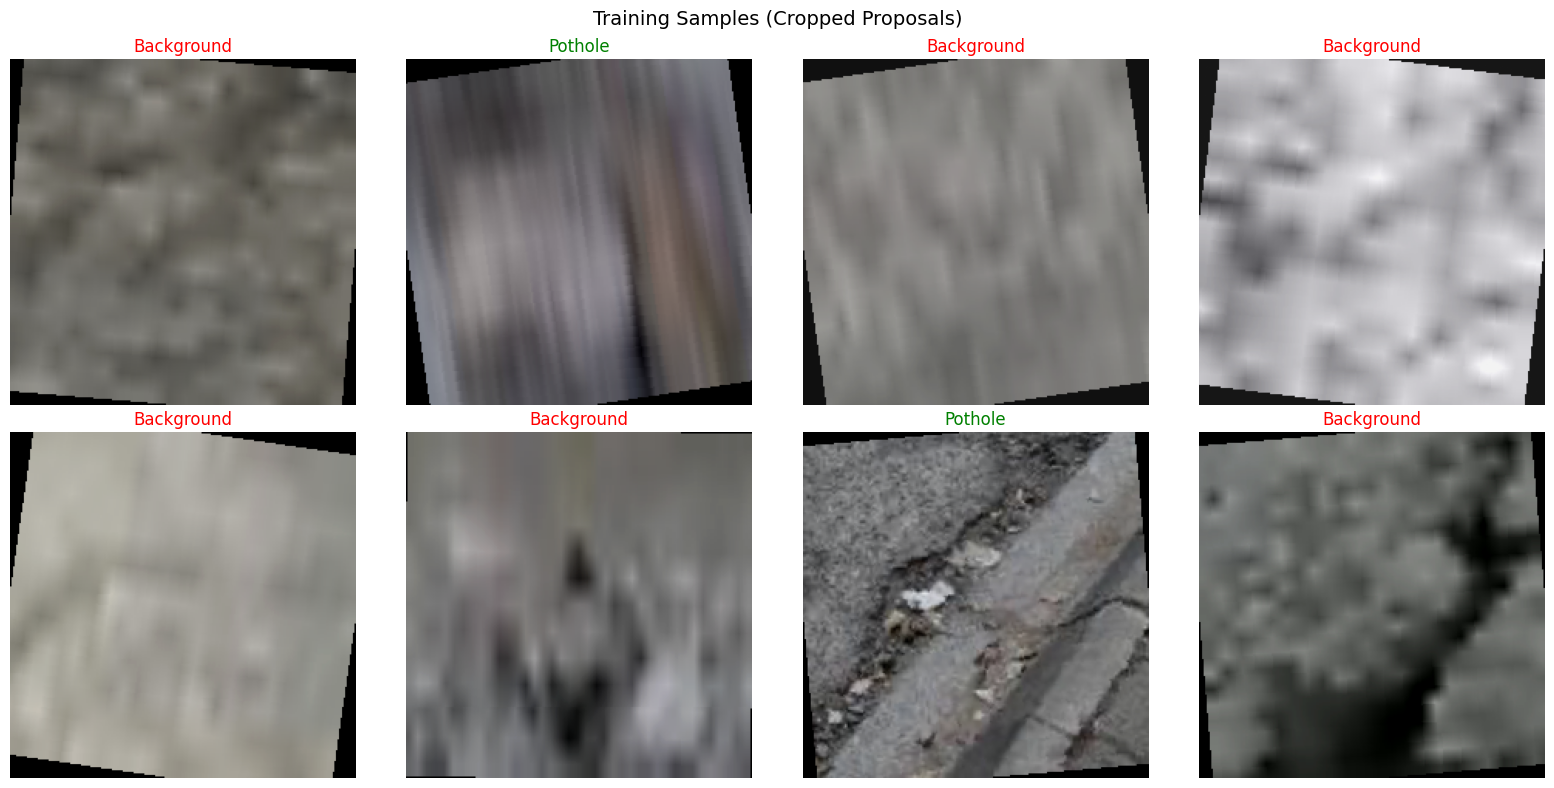

In [8]:
# Visualize some training samples
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(8):
    img = images[i].cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    label_name = 'Pothole' if labels[i] == 1 else 'Background'
    color = 'green' if labels[i] == 1 else 'red'
    axes[i].set_title(label_name, color=color)
    axes[i].axis('off')

plt.suptitle('Training Samples (Cropped Proposals)', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Get class weights for weighted loss
train_dataset = train_loader.dataset
class_weights = train_dataset.get_class_weights().to(device)
print(f"Class weights: {class_weights}")
print(f"  Background weight: {class_weights[0]:.4f}")
print(f"  Pothole weight: {class_weights[1]:.4f}")

Class weights: tensor([0.6625, 2.0384], device='mps:0')
  Background weight: 0.6625
  Pothole weight: 2.0384


## Task 3: Finetune the Network

Train the model using:
- Cross-entropy loss with class weights
- Adam optimizer with different learning rates for backbone and classifier
- Learning rate scheduling

In [10]:
# Setup training
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = get_optimizer(model, lr=LEARNING_RATE)
scheduler = get_scheduler(optimizer, patience=3, factor=0.5)

print("Training setup complete")
print(f"  Loss: CrossEntropyLoss with class weights")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau")

Training setup complete
  Loss: CrossEntropyLoss with class weights
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau


In [11]:
# Train the model
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=NUM_EPOCHS,
    save_path='best_model.pth',
    patience=5
)

Evaluating: 100%|██████████| 241/241 [00:37<00:00,  6.49it/s]



Epoch 1/15 (197.2s)
  Train Loss: 0.2250, Train Acc: 0.8680
  Val Loss: 0.2790, Val Acc: 0.8739
  Saved best model (val_acc: 0.8739)


Evaluating: 100%|██████████| 241/241 [00:37<00:00,  6.44it/s]



Epoch 2/15 (203.4s)
  Train Loss: 0.1439, Train Acc: 0.9216
  Val Loss: 0.3162, Val Acc: 0.8853
  Saved best model (val_acc: 0.8853)


Evaluating: 100%|██████████| 241/241 [00:36<00:00,  6.59it/s]



Epoch 3/15 (198.3s)
  Train Loss: 0.1176, Train Acc: 0.9405
  Val Loss: 0.2282, Val Acc: 0.9202
  Saved best model (val_acc: 0.9202)


Evaluating: 100%|██████████| 241/241 [00:36<00:00,  6.63it/s]



Epoch 4/15 (200.1s)
  Train Loss: 0.0945, Train Acc: 0.9517
  Val Loss: 0.2509, Val Acc: 0.9320
  Saved best model (val_acc: 0.9320)


Evaluating: 100%|██████████| 241/241 [00:36<00:00,  6.63it/s]



Epoch 5/15 (199.3s)
  Train Loss: 0.0831, Train Acc: 0.9586
  Val Loss: 0.3421, Val Acc: 0.8789


Evaluating: 100%|██████████| 241/241 [00:37<00:00,  6.48it/s]



Epoch 6/15 (199.6s)
  Train Loss: 0.0768, Train Acc: 0.9605
  Val Loss: 0.3120, Val Acc: 0.9068


Evaluating: 100%|██████████| 241/241 [00:35<00:00,  6.74it/s]



Epoch 7/15 (200.0s)
  Train Loss: 0.0660, Train Acc: 0.9653
  Val Loss: 0.3048, Val Acc: 0.9068


Evaluating: 100%|██████████| 241/241 [00:36<00:00,  6.69it/s]



Epoch 8/15 (199.6s)
  Train Loss: 0.0396, Train Acc: 0.9797
  Val Loss: 0.2928, Val Acc: 0.9318


Evaluating: 100%|██████████| 241/241 [00:37<00:00,  6.49it/s]


Epoch 9/15 (201.6s)
  Train Loss: 0.0315, Train Acc: 0.9853
  Val Loss: 0.2862, Val Acc: 0.9303

Early stopping at epoch 9


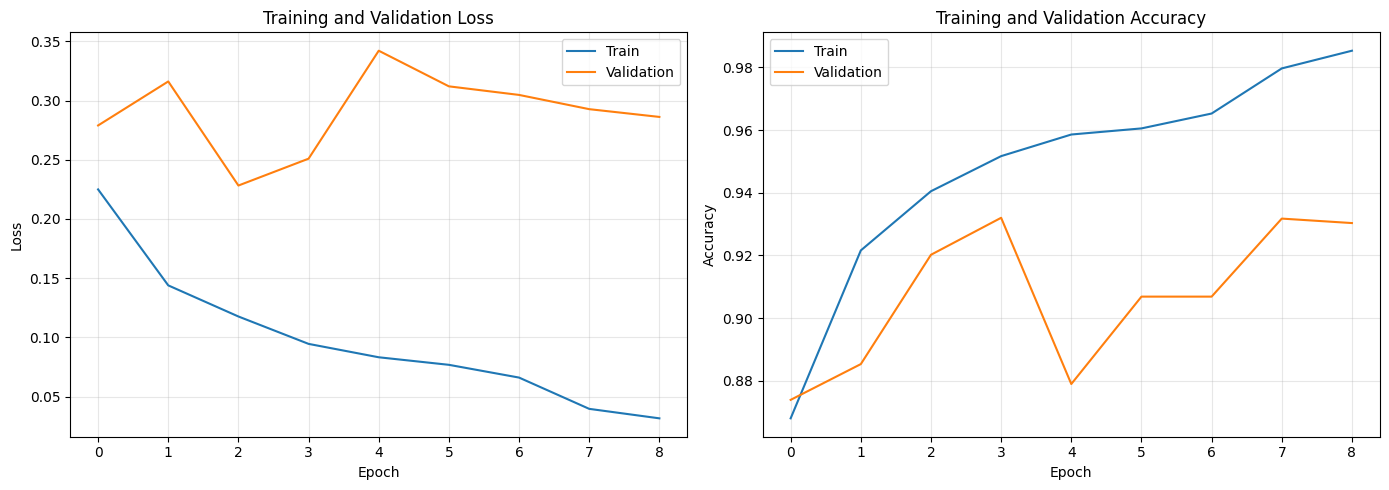


Best validation accuracy: 0.9320


In [12]:
# Plot training history
fig = plot_training_history(history)
plt.show()

print(f"\nBest validation accuracy: {max(history['val_acc']):.4f}")

## Task 4: Evaluate Classification Accuracy

Evaluate the trained model on the validation set and report:
- Overall accuracy
- Per-class accuracy
- Precision, recall, F1-score
- Confusion matrix

In [13]:
# Load best model
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")

Loaded best model from epoch 4
Validation accuracy: 0.9320


In [14]:
# Evaluate on validation set
val_loss, val_acc, preds, labels = evaluate(model, val_loader, criterion, device)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")

Evaluating: 100%|██████████| 241/241 [00:36<00:00,  6.55it/s]


Validation Results:
  Loss: 0.2509
  Accuracy: 0.9320


In [15]:
# Detailed evaluation report
print_evaluation_report(preds, labels, class_names=['background', 'pothole'])


Classification Report
              precision    recall  f1-score   support

  background       0.97      0.95      0.96      6612
     pothole       0.73      0.82      0.77      1095

    accuracy                           0.93      7707
   macro avg       0.85      0.89      0.87      7707
weighted avg       0.94      0.93      0.93      7707


Confusion Matrix:
              Predicted
              background    pothole
Actual background       6282        330
          pothole        194        901

Per-class Accuracy:
  background: 0.9501
  pothole: 0.8228


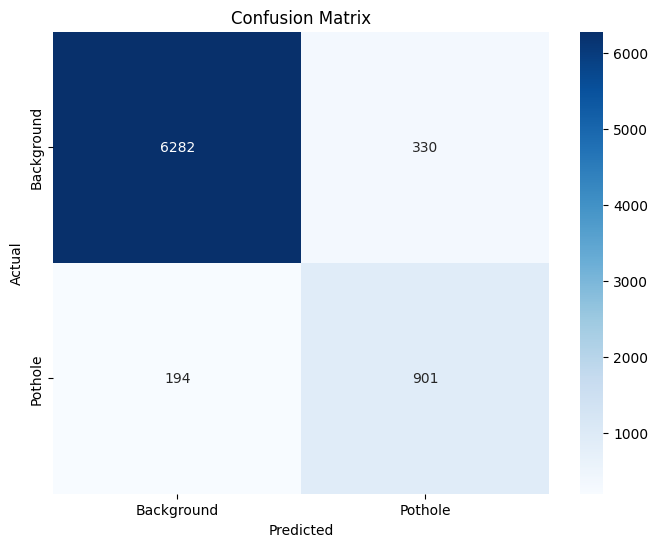

In [16]:
# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Pothole'],
            yticklabels=['Background', 'Pothole'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/Users/williampeytz/Documents/GitHub/DLCV4/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


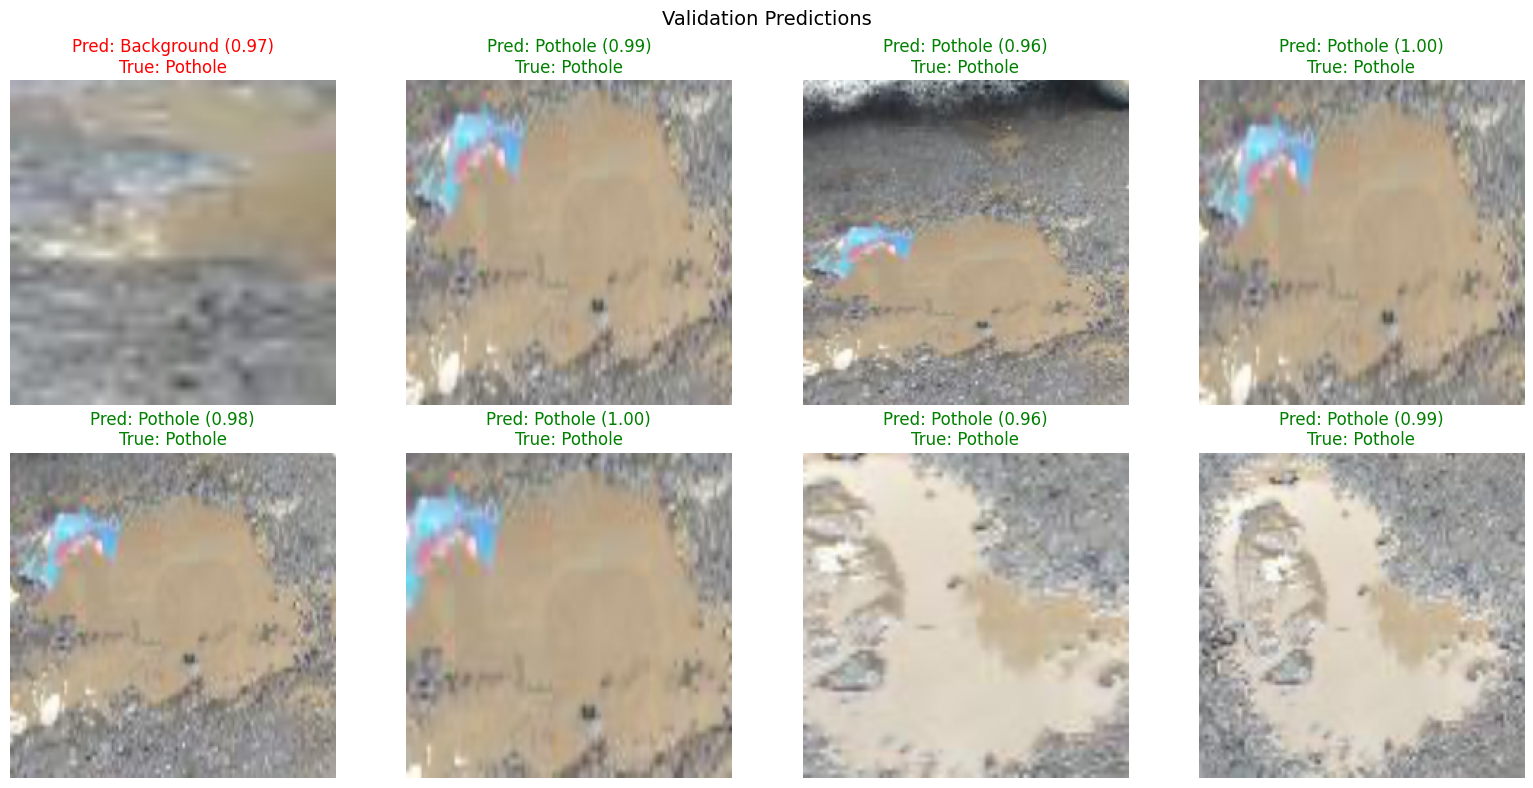

In [17]:
# Visualize some predictions
model.eval()
images, true_labels = next(iter(val_loader))

with torch.no_grad():
    outputs = model(images.to(device))
    probs = torch.softmax(outputs, dim=1)
    _, pred_labels = outputs.max(1)

# Plot predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(8):
    img = images[i].cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    
    pred = pred_labels[i].item()
    true = true_labels[i].item()
    prob = probs[i, pred].item()
    
    pred_name = 'Pothole' if pred == 1 else 'Background'
    true_name = 'Pothole' if true == 1 else 'Background'
    
    color = 'green' if pred == true else 'red'
    axes[i].set_title(f'Pred: {pred_name} ({prob:.2f})\nTrue: {true_name}', color=color)
    axes[i].axis('off')

plt.suptitle('Validation Predictions', fontsize=14)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we:

1. **Built a CNN classifier**: ResNet18 backbone with custom classification head
2. **Created balanced data loaders**: Used weighted sampling and limited neg/pos ratio
3. **Trained the network**: Fine-tuned on the pothole dataset
4. **Evaluated accuracy**: Measured classification performance on validation set

### Key Results:
- Validation Accuracy: [FILL IN]
- Pothole Recall: [FILL IN]
- Background Precision: [FILL IN]

### Notes:
- This is **classification accuracy** on proposals, not object detection mAP
- The model can now be used in Part 4.3 for full detection pipeline